# Car Classification

**Цель** - подготовить и обучить нейросеть для распознавания моделей автомобилей на картинках

**Задачи:**
 - разобрать baseline-проект
 - изучить различные практики и подходы улучшения качества нейросетей, такие как transfer learning с fine-tuning, использование callback Keras, ТТА и др.
 - применить изученные подходы к текущему проекту
 - попрактиковаться в решении задач компьтерного зрения на практике
 - добавить в портфолио еще один проект

**Основная идея данного проекта** - взять предобученую на сеть, например Xception или EfficientNet, и дообучить под нашу задачу. 






# 1. Import

In [1]:
# подключи видеокарту, карл!
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-a5305b64-10b5-6d47-544a-0b83ad0a602c)


In [2]:
# Проверим, что подключена видеокарта
!nvidia-smi

Sat Nov 13 10:28:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Установим недостающие пакеты

In [3]:
# Загружаем обвязку под keras для использования продвинутых библиотек аугментации, например, albuminations
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor -q

     |████████████████████████████████| 60.3 MB 59 kB/s 
     |████████████████████████████████| 631 kB 49.3 MB/s 


In [4]:
# Установим пакет с обученными сетями EfficientNetB3, EfficientNetB5, EfficientNetB6...
!pip install -q efficientnet

     |████████████████████████████████| 50 kB 6.1 MB/s 


In [5]:
!pip install -U albumentations

     |████████████████████████████████| 102 kB 14.8 MB/s 
     |████████████████████████████████| 47.6 MB 65 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


## Импортируем все необходимые пакеты

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os
import itertools

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *

import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from keras.callbacks import LearningRateScheduler,EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

from sklearn.model_selection import train_test_split, StratifiedKFold

from ImageDataAugmentor.image_data_augmentor import *
import albumentations as alb_aug

import efficientnet.tfkeras as efn

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

#print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.7.12 (default, Sep 10 2021, 00:21:48) 
Numpy        : 1.19.5
Tensorflow   : 2.7.0
Keras        : 2.7.0


**Работаем с Tensorflow v2.6**

## Для воспроизводимости сохраним версии всех пакетов

In [7]:
!pip freeze > requirements.txt

In [8]:
# подготавливаем данные

# для Google Colab:
!gsutil cp gs://oleg-zyablov/skillfactory/sf-dl-car-classification.zip .
!unzip sf-dl-car-classification.zip

#имена классов
class_names = [
  'Приора', #0
  'Ford Focus', #1
  'Самара', #2
  'ВАЗ-2110', #3
  'Жигули', #4
  'Нива', #5
  'Калина', #6
  'ВАЗ-2109', #7
  'Volkswagen Passat', #8
  'ВАЗ-21099' #9
]

Copying gs://oleg-zyablov/skillfactory/sf-dl-car-classification.zip...
/ [1 files][  1.6 GiB/  1.6 GiB]   65.0 MiB/s                                   
Operation completed over 1 objects/1.6 GiB.                                      
Archive:  sf-dl-car-classification.zip
   creating: sf-dl-car-classification/
  inflating: sf-dl-car-classification/sample-submission.csv  
  inflating: sf-dl-car-classification/train.csv  
 extracting: sf-dl-car-classification/test.zip  
 extracting: sf-dl-car-classification/train.zip  


# 2. Setup

In [9]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 8    # эпох на обучение
BATCH_SIZE           = 16    # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-3
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10   # количество классов в нашей задаче
IMG_SIZE             = (165, 220)  # какого размера подаем изображения в сеть
# IMG_SIZE             = (384, 512) 
IMG_CHANNELS         = 3    # у RGB 3 канала
input_shape          = (*IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/content/sf-dl-car-classification/'
PATH = "/content/car/" # рабочая директория
DRIVE_PATH = '/content/drive/MyDrive/Colab Notebooks/SF_Models/' # google drive

STEP = 'step_0'

#MODEL = "efficient-b3"
#MODEL = 'Xception'
MODEL = 'EfficientNetB5'
#MODEL = 'EfficientNetB6'

In [10]:
# Словарь для сохранения точности модели на разных шагах
accuracy_dict = dict()

# Проверяем наличие директории
os.makedirs(PATH, exist_ok=False)

# Устаналиваем конкретное значение random seed для воспроизводимости
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

In [11]:
# Подключаем google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3. Data

In [12]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [14]:
train_df.Category.value_counts()
# распределение классов достаточно равномерное - это хорошо

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [15]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile(DATA_PATH+data_zip, "r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['train', 'test_upload']


Пример картинок (random sample)


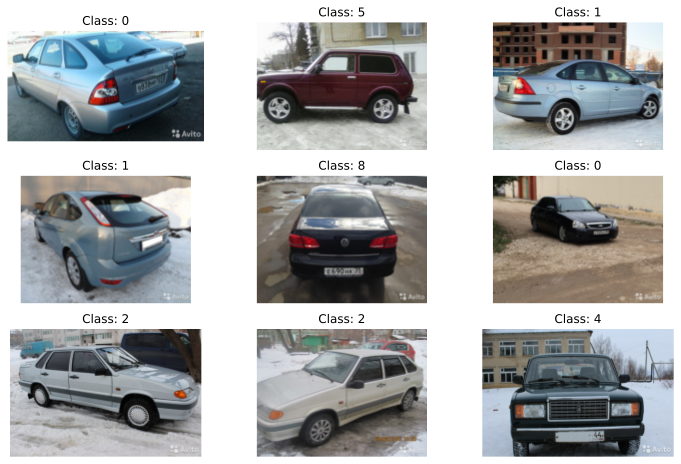

In [16]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

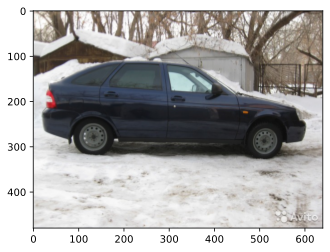

(640, 480)

In [17]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# 4. Cleaning and Prepping Data

## Определим вспомогательные функции

In [18]:
def show_first_images(generator, count=6, labels=True, figsize=(20, 5), normalized=False):
    generator = itertools.islice(generator, count)
    fig, axes = plt.subplots(nrows=1, ncols=count, figsize=figsize)
    for batch, ax in zip(generator, axes):
        if labels:
            img_batch, labels_batch = batch
            img, label = img_batch[0], np.argmax(labels_batch[0]) #берем по одному изображению из каждого батча
        else:
            img_batch = batch
            img = img_batch[0]
        if not normalized:
            img = img.astype(np.uint8)
        ax.imshow(img)
        # метод imshow принимает одно из двух:
        # - изображение в формате uint8, яркость от 0 до 255
        # - изображение в формате float, яркость от 0 до 1
        if labels:
            ax.set_title(f'Class: {label}')
    plt.show()

In [19]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [20]:
def print_accuracy_dict(accuracy_dict):
    print(f'Fine-tuning {MODEL}')
    for accuracy_type, accuracy_value in accuracy_dict.items():
        print(f'{accuracy_type} accuracy {accuracy_value}')

## Аугментация данных

Посмотрим два варианта аугментации данных



### Аугментация встроенными методами

In [21]:
my_datagen_classic = ImageDataGenerator(
    rescale=1. / 255, 
    rotation_range = 50,
    shear_range=0.2,
    zoom_range=[0.75,1.25],
    brightness_range=[0.5, 1.5],
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

Found 15561 images belonging to 10 classes.


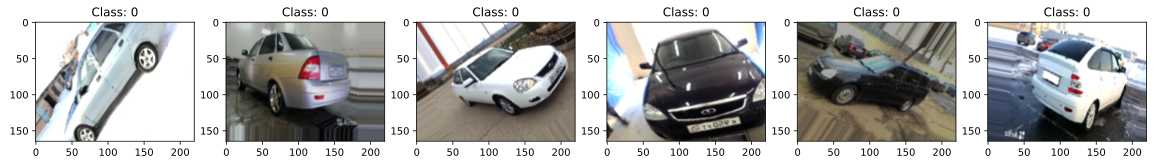

Found 15561 images belonging to 10 classes.


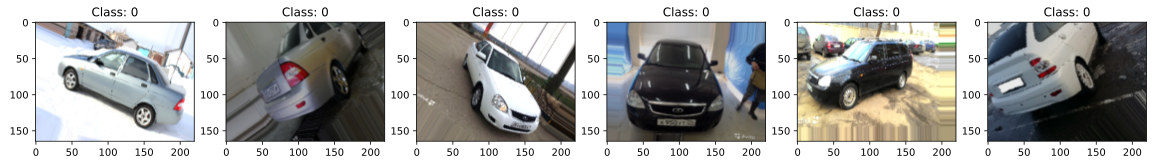

Found 15561 images belonging to 10 classes.


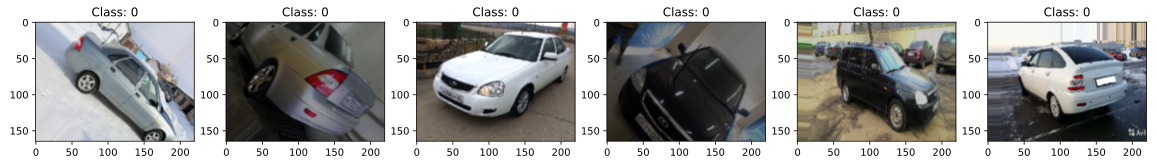

In [22]:
for _ in range(3):
    my_generator = my_datagen_classic.flow_from_directory(
        PATH+'train/',      # директория где расположены папки с картинками
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        # seed=RANDOM_SEED,
        subset='training'
    )
    show_first_images(my_generator, normalized=True)

### Аугментация с помощью библиотеки albumentations

In [23]:
alb_aug.__version__

'1.1.0'

In [24]:
AUGMENTATIONS = alb_aug.Compose([
    alb_aug.HorizontalFlip(p=0.5),
    alb_aug.ShiftScaleRotate(
        shift_limit=0.0625, 
        scale_limit=0.01, 
        interpolation=1, 
        border_mode=4, 
        rotate_limit=20, 
        p=.75
    ),
    alb_aug.OneOf([
        alb_aug.CenterCrop(height=150, width=120),
        alb_aug.CenterCrop(height=150, width=220),
    ],p=0.5),
    alb_aug.OneOf([
        alb_aug.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        alb_aug.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    alb_aug.Cutout(p=0.5, num_holes=1, max_h_size=30, max_w_size=50), #первый раз
    alb_aug.Cutout(p=0.5, num_holes=1, max_h_size=40, max_w_size=70),  #второй раз
    #alb_aug.GaussianBlur(p=0.05),
    alb_aug.RandomBrightness(limit=0.2, p=0.5),
    alb_aug.HueSaturationValue(p=0.5),
    alb_aug.RGBShift(p=0.5),
    alb_aug.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    alb_aug.Resize(*IMG_SIZE)
])

def print_aug_image(image):
    image = image.astype(np.uint8)
    return AUGMENTATIONS(image=image)['image']

my_datagen_albu = ImageDataGenerator(
    preprocessing_function=print_aug_image
)

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


Found 15561 images belonging to 10 classes.


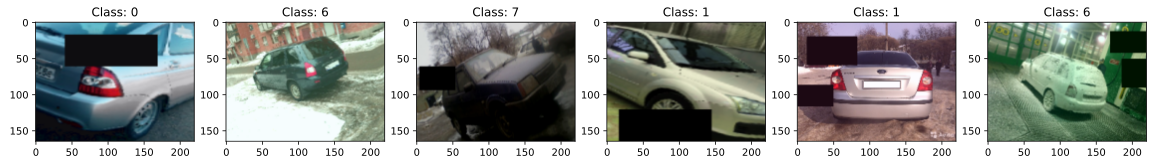

Found 15561 images belonging to 10 classes.


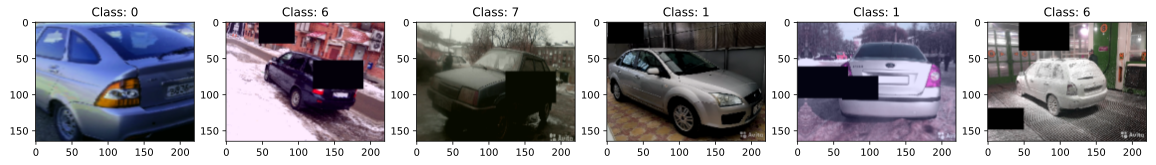

Found 15561 images belonging to 10 classes.


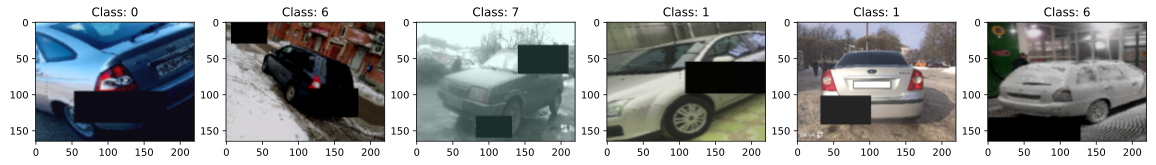

In [25]:
for _ in range(3):
    my_generator = my_datagen_albu.flow_from_directory(
        PATH+'train/',      # директория где расположены папки с картинками
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=RANDOM_SEED,
        subset='training'
    )
    show_first_images(my_generator)

**Итого:** Аугментация с помощью библиотеки Albumentations получается шире. Для нашей задачи возьмем именно такой способ.

## Генерация данных

Произведем аугментацию и завернем наши данные в генераторы

In [26]:
# Произведем аугментацию данных
train_datagen = ImageDataAugmentor(
    rescale=1./255,
    augment = AUGMENTATIONS,
    validation_split=VAL_SPLIT,
)

valid_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=VAL_SPLIT,
)

test_datagen = ImageDataGenerator(
    rescale=1. / 255,
)

# Завернем наши данные в генератор:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='training'
) # set as training data

test_valid_generator = valid_datagen.flow_from_directory(
    PATH+'train/',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='validation'
) # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

/usr/local/lib/python3.7/dist-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


Посмотрим на полившиеся данные генераторов

Train:


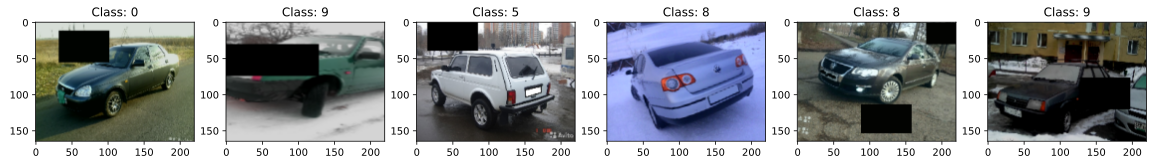

Val:


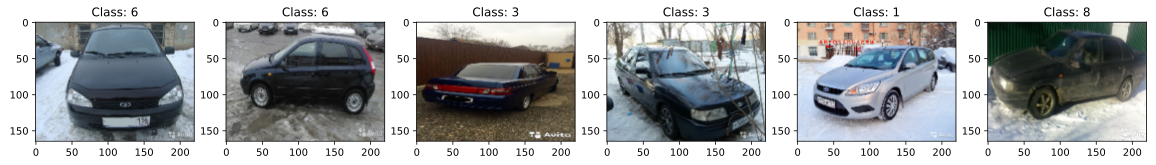

Sub:


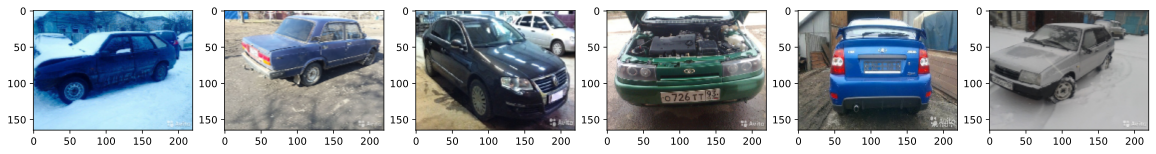

In [27]:
print('Train:')
show_first_images(train_generator, labels=True, normalized=True)

print('Val:')
show_first_images(test_valid_generator, labels=True, normalized=True)

print('Sub:')
show_first_images(test_sub_generator, labels=False, normalized=True)

# 5. Model

## Базовая модель

Загружаем предобученную сеть

In [28]:
# base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

# base_model = efn.EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)

base_model = efn.EfficientNetB5(weights='imagenet', include_top=False, input_shape=input_shape)

# base_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=input_shape)

115523584/115515256 [==============================] - 1s 0us/step


In [29]:
base_model.summary()

Model: "efficientnet-b5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 165, 220, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 83, 110, 48)  1296        ['input_1[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 83, 110, 48)  192         ['stem_conv[0][0]']              
                                                                                                  
 stem_activation (Activation)   (None, 83, 110, 48)  0           ['stem_bn[0][0]']  

## "Голова" Модели

In [30]:
# Устанавливаем новую "голову" (head)
model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),) # объединяем все признаки в единый вектор 
model.add(L.Dense(256, activation='relu', bias_regularizer=l2(1e-4), activity_regularizer=l2(1e-5)))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.25))
model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b5 (Functional  (None, 6, 7, 2048)       28513520  
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

## Обучение модели

### Коллбэки

Определим коллбэки для нашей будущей модели. В частности добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [32]:
callback_early_stopping = EarlyStopping(monitor='accuracy', patience=5, verbose=1)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=1e-6, patience=2, verbose=1)

callback_checkpoint = ModelCheckpoint(f'{MODEL}_best.hdf5', monitor=['val_acc'], verbose=1, mode ='max') 

# callback_learing_rate = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x),    
# path_checkpoint = 'checkpoint.keras'
# ModelCheckpoint(filepath=path_checkpoint,monitor='val_loss',verbose=1,save_weights_only=True, save_best_only=True)

callbacks = [callback_checkpoint, callback_reduce_lr, callback_early_stopping]

### Step 1. Обучаем только голову модели

Для начала заморозим веса базовой и обучим только "голову". Делаем это для того, чтобы хорошо обученные признаки на Imagenet не затирались в самом начале нашего обучения

In [33]:
# Для начала заморозим веса базовой и обучим только "голову". 
# Делаем это для того, чтобы хорошо обученные признаки на Imagenet не затирались в самом начале нашего обучения
base_model.trainable = False

# сколько слоев
print(len(model.layers))
len(model.trainable_variables)
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

6
<keras.engine.functional.Functional object at 0x7eff43849550> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7eff438175d0> True
<keras.layers.core.dense.Dense object at 0x7eff43056cd0> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7eff43055ad0> True
<keras.layers.core.dropout.Dropout object at 0x7eff46a64850> True
<keras.layers.core.dense.Dense object at 0x7eff471a95d0> True


In [34]:
STEP  = 'step_1'

model.compile(
    loss="categorical_crossentropy", 
    optimizer=optimizers.Adam(learning_rate=LR), 
    metrics=["accuracy"]
)

In [35]:
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_valid_generator, 
        validation_steps = len(test_valid_generator),
        epochs = EPOCHS,
        callbacks = callbacks
)

Epoch 1/8
827/827 [==============================] - ETA: 0s - loss: 1.9368 - accuracy: 0.3456
Epoch 00001: saving model to EfficientNetB5_best.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


827/827 [==============================] - 170s 172ms/step - loss: 1.9368 - accuracy: 0.3456 - val_loss: 1.2562 - val_accuracy: 0.5483 - lr: 0.0010
Epoch 2/8
827/827 [==============================] - ETA: 0s - loss: 1.6361 - accuracy: 0.4183
Epoch 00002: saving model to EfficientNetB5_best.hdf5
827/827 [==============================] - 141s 170ms/step - loss: 1.6361 - accuracy: 0.4183 - val_loss: 1.1310 - val_accuracy: 0.6058 - lr: 0.0010
Epoch 3/8
827/827 [==============================] - ETA: 0s - loss: 1.5633 - accuracy: 0.4483
Epoch 00003: saving model to EfficientNetB5_best.hdf5
827/827 [==============================] - 141s 171ms/step - loss: 1.5633 - accuracy: 0.4483 - val_loss: 1.1496 - val_accuracy: 0.6071 - lr: 0.0010
Epoch 4/8
827/827 [==============================] - ETA: 0s - loss: 1.5156 - accuracy: 0.4564
Epoch 00004: saving model to EfficientNetB5_best.hdf5
827/827 [==============================] - 143s 173ms/step - loss: 1.5156 - accuracy: 0.4564 - val_loss: 1.00

In [36]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении 
model.save(f'{MODEL}_last.hdf5')
model.load_weights(f'{MODEL}_best.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [37]:
# сщхраним на google drive лучший вариант модели на этом шаге
os.popen(f'cp /content/{MODEL}_best.hdf5 "{DRIVE_PATH}{MODEL}_{STEP}_best.hdf5"')

In [38]:
scores = model.evaluate(test_valid_generator, steps=len(test_valid_generator), verbose=1)
accuracy_dict['0% weights defrosting'] = "%.2f%%" % (scores[1]*100)

# Напечатаем значения accuracy на различных steps
print_accuracy_dict(accuracy_dict)

146/146 [==============================] - 15s 104ms/step - loss: 0.9462 - accuracy: 0.6728
Fine-tuning EfficientNetB5
0% weights defrosting accuracy 67.28%


Посмотрим графики обучения:

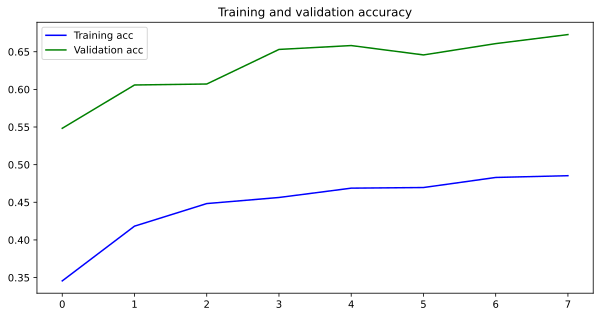

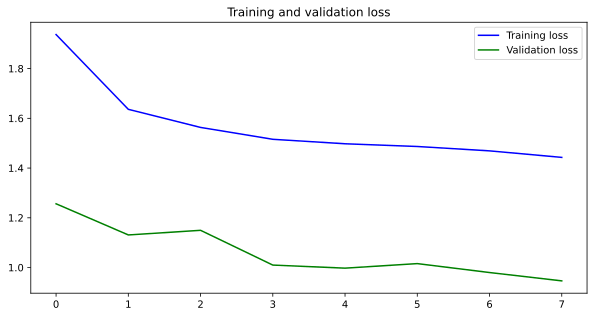

In [39]:
plot_history(history)

### Step 2. Размораживаем веса в половине слоев базовой модели

In [40]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

print("Number of layers in the base model: ", len(base_model.layers))    
print('Number of defrosted layers in the base model: ', len(base_model.trainable_variables))

<keras.engine.functional.Functional object at 0x7eff43849550> True
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7eff438175d0> True
<keras.layers.core.dense.Dense object at 0x7eff43056cd0> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7eff43055ad0> True
<keras.layers.core.dropout.Dropout object at 0x7eff46a64850> True
<keras.layers.core.dense.Dense object at 0x7eff471a95d0> True
Number of layers in the base model:  569
Number of defrosted layers in the base model:  252


In [41]:
EPOCHS = 15    # увеличим число эпох на обучение
LR     = 1e-3  # уменьшаем learning_rate
STEP   = 'step_2'

model.compile(
    loss="categorical_crossentropy", 
    optimizer=optimizers.Adam(learning_rate=LR), 
    metrics=["accuracy"]
)

In [42]:
# Обучаем
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_valid_generator, 
        validation_steps = len(test_valid_generator),
        epochs = EPOCHS,
        callbacks = callbacks
)

Epoch 1/15
827/827 [==============================] - ETA: 0s - loss: 1.2630 - accuracy: 0.5689
Epoch 00001: saving model to EfficientNetB5_best.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


827/827 [==============================] - 188s 207ms/step - loss: 1.2630 - accuracy: 0.5689 - val_loss: 0.6512 - val_accuracy: 0.7892 - lr: 0.0010
Epoch 2/15
827/827 [==============================] - ETA: 0s - loss: 0.8154 - accuracy: 0.7192
Epoch 00002: saving model to EfficientNetB5_best.hdf5
827/827 [==============================] - 171s 206ms/step - loss: 0.8154 - accuracy: 0.7192 - val_loss: 0.4092 - val_accuracy: 0.8682 - lr: 0.0010
Epoch 3/15
827/827 [==============================] - ETA: 0s - loss: 0.6789 - accuracy: 0.7675
Epoch 00003: saving model to EfficientNetB5_best.hdf5
827/827 [==============================] - 167s 202ms/step - loss: 0.6789 - accuracy: 0.7675 - val_loss: 0.3694 - val_accuracy: 0.8742 - lr: 0.0010
Epoch 4/15
827/827 [==============================] - ETA: 0s - loss: 0.6000 - accuracy: 0.7963
Epoch 00004: saving model to EfficientNetB5_best.hdf5
827/827 [==============================] - 166s 201ms/step - loss: 0.6000 - accuracy: 0.7963 - val_loss: 0

In [43]:
model.save(f'{MODEL}_last_finetuning.hdf5')
model.load_weights(f'{MODEL}_best.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [44]:
# сщхраним на google drive лучший вариант модели на этом шаге
os.popen(f'cp /content/{MODEL}_best.hdf5 "{DRIVE_PATH}{MODEL}_{STEP}_best.hdf5"')

In [45]:
scores = model.evaluate_generator(test_valid_generator, verbose=1)
accuracy_dict['50% weights defrosting'] = "%.2f%%" % (scores[1]*100)

# Напечатаем значения accuracy на различных steps
print_accuracy_dict(accuracy_dict)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


146/146 [==============================] - 16s 108ms/step - loss: 0.1606 - accuracy: 0.9480
Fine-tuning EfficientNetB5
0% weights defrosting accuracy 67.28%
50% weights defrosting accuracy 94.80%


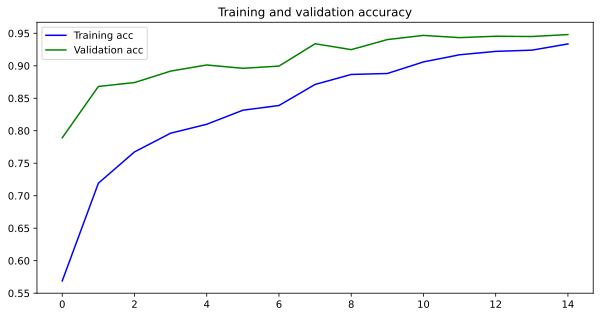

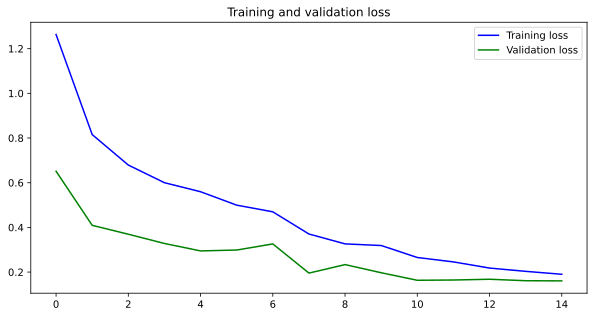

In [46]:
plot_history(history)

### Step 3. Размораживаем веса в 75% слоев базовой модели

In [47]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//4

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

print("Number of layers in the base model: ", len(base_model.layers))    
print('Number of defrosted layers in the base model: ', len(base_model.trainable_variables))

<keras.engine.functional.Functional object at 0x7eff43849550> True
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7eff438175d0> True
<keras.layers.core.dense.Dense object at 0x7eff43056cd0> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7eff43055ad0> True
<keras.layers.core.dropout.Dropout object at 0x7eff46a64850> True
<keras.layers.core.dense.Dense object at 0x7eff471a95d0> True
Number of layers in the base model:  569
Number of defrosted layers in the base model:  377


In [48]:
EPOCHS = 12    # увеличим число эпох на обучение
LR     = 1e-4  # уменьшаем learning_rate
STEP   = 'step_3'

model.compile(
    loss="categorical_crossentropy", 
    optimizer=optimizers.Adam(learning_rate=LR), 
    metrics=["accuracy"]
)

In [49]:
# Обучаем
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_valid_generator, 
        validation_steps = len(test_valid_generator),
        epochs = EPOCHS,
        callbacks = callbacks
)

Epoch 1/12
827/827 [==============================] - ETA: 0s - loss: 0.2151 - accuracy: 0.9211
Epoch 00001: saving model to EfficientNetB5_best.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


827/827 [==============================] - 198s 216ms/step - loss: 0.2151 - accuracy: 0.9211 - val_loss: 0.1637 - val_accuracy: 0.9468 - lr: 1.0000e-04
Epoch 2/12
827/827 [==============================] - ETA: 0s - loss: 0.1899 - accuracy: 0.9318
Epoch 00002: saving model to EfficientNetB5_best.hdf5
827/827 [==============================] - 176s 212ms/step - loss: 0.1899 - accuracy: 0.9318 - val_loss: 0.1549 - val_accuracy: 0.9459 - lr: 1.0000e-04
Epoch 3/12
827/827 [==============================] - ETA: 0s - loss: 0.1814 - accuracy: 0.9364
Epoch 00003: saving model to EfficientNetB5_best.hdf5
827/827 [==============================] - 176s 212ms/step - loss: 0.1814 - accuracy: 0.9364 - val_loss: 0.1515 - val_accuracy: 0.9515 - lr: 1.0000e-04
Epoch 4/12
827/827 [==============================] - ETA: 0s - loss: 0.1703 - accuracy: 0.9398
Epoch 00004: saving model to EfficientNetB5_best.hdf5
827/827 [==============================] - 177s 213ms/step - loss: 0.1703 - accuracy: 0.9398 -

In [50]:
model.save(f'{MODEL}_last_finetuning.hdf5')
model.load_weights(f'{MODEL}_best.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [51]:
# сщхраним на google drive лучший вариант модели на этом шаге
os.popen(f'cp /content/{MODEL}_best.hdf5 "{DRIVE_PATH}{MODEL}_{STEP}_best.hdf5"')

In [52]:
scores = model.evaluate_generator(test_valid_generator, verbose=1)
accuracy_dict['75% weights defrosting'] = "%.2f%%" % (scores[1]*100)

# Напечатаем значения accuracy на различных steps
print_accuracy_dict(accuracy_dict)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


146/146 [==============================] - 17s 113ms/step - loss: 0.1472 - accuracy: 0.9549
Fine-tuning EfficientNetB5
0% weights defrosting accuracy 67.28%
50% weights defrosting accuracy 94.80%
75% weights defrosting accuracy 95.49%


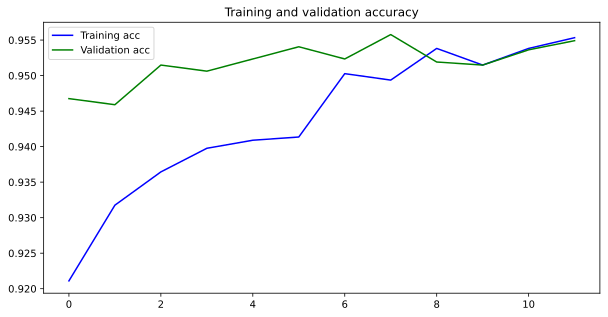

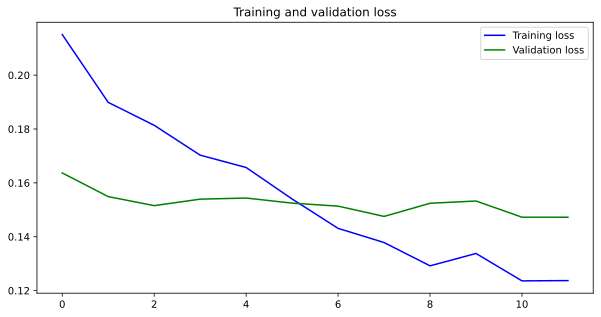

In [53]:
plot_history(history)

In [54]:
%%script false
# Подготовим модель к загрузке сохраненных весов после 3-го шага
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//4

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

model.compile(
    loss="categorical_crossentropy", 
    optimizer=optimizers.Adam(learning_rate=LR), 
    metrics=["accuracy"]
)

# сщхраним на google drive лучший вариант модели на этом шаге
os.popen(f'cp "{DRIVE_PATH}{MODEL}_step_3_best.hdf5" /content/{MODEL}_best.hdf5')



In [55]:
%%script false
# Загрузим сохраненные веса после 3-го шага
model.load_weights(f'{MODEL}_best.hdf5')

scores = model.evaluate_generator(test_valid_generator, verbose=1)
accuracy_dict['75% weights defrosting'] = "%.2f%%" % (scores[1]*100)

# Напечатаем значения accuracy на различных steps
print_accuracy_dict(accuracy_dict)

### Step 4. Размораживаем веса во всех слоях базовой модели и увеличим разрешение изображений


Разморозим веса в модели:

In [56]:
base_model.trainable = True

# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

print("Number of layers in the base model: ", len(base_model.layers))    
print('Number of defrosted layers in the base model: ', len(base_model.trainable_variables))

<keras.engine.functional.Functional object at 0x7eff43849550> True
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7eff438175d0> True
<keras.layers.core.dense.Dense object at 0x7eff43056cd0> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7eff43055ad0> True
<keras.layers.core.dropout.Dropout object at 0x7eff46a64850> True
<keras.layers.core.dense.Dense object at 0x7eff471a95d0> True
Number of layers in the base model:  569
Number of defrosted layers in the base model:  504


Поменяем параметры модели, в частности увеличим разрешение изображений и подберем количество эпох и батч, чтобы не перегрузить видеокарту

In [57]:
EPOCHS     = 10    # увеличим число эпох на обучение
LR         = 1e-5  # уменьшаем learning_rate
STEP       = 'step_4'
BATCH_SIZE = 4
IMG_SIZE   = (384, 512)

model.compile(
    loss="categorical_crossentropy", 
    optimizer=optimizers.Adam(learning_rate=LR), 
    metrics=["accuracy"]
)

Упростим аугментацию изображений

In [58]:
AUGMENTATIONS = alb_aug.Compose([
    alb_aug.HorizontalFlip(p=0.5),
    alb_aug.ShiftScaleRotate(
        shift_limit=0.0625, 
        scale_limit=0.01, 
        interpolation=1, 
        border_mode=4, 
        rotate_limit=20, 
        p=.75
    ),
    alb_aug.RandomBrightness(limit=0.2, p=0.5),
    alb_aug.Resize(*IMG_SIZE)
])

# Произведем аугментацию данных
train_datagen = ImageDataAugmentor(
    rescale=1./255,
    augment = AUGMENTATIONS,
    validation_split=VAL_SPLIT,
)

valid_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=VAL_SPLIT,
)

test_datagen = ImageDataGenerator(
    rescale=1. / 255,
)

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [59]:
# Завернем наши данные в генератор:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='training'
) # set as training data

test_valid_generator = valid_datagen.flow_from_directory(
    PATH+'train/',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='validation'
) # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

/usr/local/lib/python3.7/dist-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [60]:
# Обучаем
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_valid_generator, 
        validation_steps = len(test_valid_generator),
        epochs = EPOCHS,
        callbacks = callbacks
)

Epoch 1/10
3308/3308 [==============================] - ETA: 0s - loss: 0.5709 - accuracy: 0.8266
Epoch 00001: saving model to EfficientNetB5_best.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


3308/3308 [==============================] - 1430s 426ms/step - loss: 0.5709 - accuracy: 0.8266 - val_loss: 0.1503 - val_accuracy: 0.9532 - lr: 1.0000e-05
Epoch 2/10
3308/3308 [==============================] - ETA: 0s - loss: 0.3388 - accuracy: 0.8959
Epoch 00002: saving model to EfficientNetB5_best.hdf5
3308/3308 [==============================] - 1405s 425ms/step - loss: 0.3388 - accuracy: 0.8959 - val_loss: 0.1112 - val_accuracy: 0.9614 - lr: 1.0000e-05
Epoch 3/10
3308/3308 [==============================] - ETA: 0s - loss: 0.2685 - accuracy: 0.9200
Epoch 00003: saving model to EfficientNetB5_best.hdf5
3308/3308 [==============================] - 1407s 425ms/step - loss: 0.2685 - accuracy: 0.9200 - val_loss: 0.0989 - val_accuracy: 0.9678 - lr: 1.0000e-05
Epoch 4/10
3308/3308 [==============================] - ETA: 0s - loss: 0.2245 - accuracy: 0.9332
Epoch 00004: saving model to EfficientNetB5_best.hdf5
3308/3308 [==============================] - 1406s 425ms/step - loss: 0.2245 - 

In [61]:
model.save(f'{MODEL}_last_finetuning.hdf5')
model.load_weights(f'{MODEL}_best.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [62]:
# сщхраним на google drive лучший вариант модели на этом шаге
os.popen(f'cp /content/{MODEL}_best.hdf5 "{DRIVE_PATH}{MODEL}_{STEP}_best.hdf5"')

In [63]:
scores = model.evaluate_generator(test_valid_generator, verbose=1)
accuracy_dict['100% weights defrosting'] = "%.2f%%" % (scores[1]*100)

# Напечатаем значения accuracy на различных steps
print_accuracy_dict(accuracy_dict)

  1/583 [..............................] - ETA: 1:17 - loss: 0.0029 - accuracy: 1.0000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


583/583 [==============================] - 46s 79ms/step - loss: 0.0869 - accuracy: 0.9717
Fine-tuning EfficientNetB5
0% weights defrosting accuracy 67.28%
50% weights defrosting accuracy 94.80%
75% weights defrosting accuracy 95.49%
100% weights defrosting accuracy 97.17%


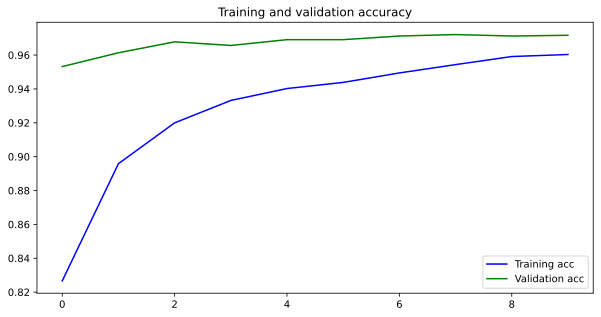

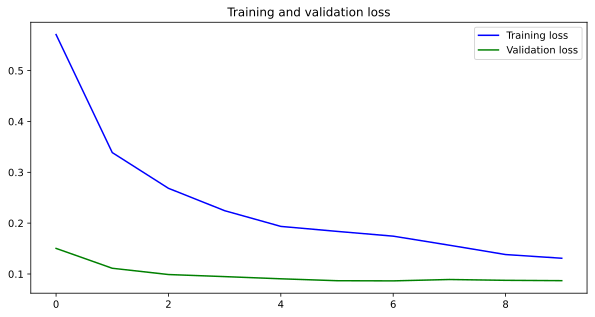

In [64]:
plot_history(history)

# 6. Submission

In [65]:
test_sub_generator.samples

6675

In [66]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


1669/1669 [==============================] - 117s 69ms/step


In [67]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [68]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,7


In [69]:
%%script false
# Подгтовим модель к загрузке сохраненных весов после 4-го шага
base_model.trainable = True
    
model.compile(
    loss="categorical_crossentropy", 
    optimizer=optimizers.Adam(learning_rate=LR), 
    metrics=["accuracy"]
)

# сщхраним на google drive лучший вариант модели на этом шаге
os.popen(f'cp "{DRIVE_PATH}{MODEL}_step_4_best.hdf5" /content/{MODEL}_best.hdf5')


In [70]:
%%script false
# Загрузим сохраненные веса после 4-го шага
model.load_weights(f'{MODEL}_best.hdf5')

scores = model.evaluate_generator(test_valid_generator, verbose=1)
accuracy_dict['100% weights defrosting'] = "%.2f%%" % (scores[1]*100)

# Напечатаем значения accuracy на различных steps
print_accuracy_dict(accuracy_dict)

# 7. Test Time Augmentation

**Test-time augmentations (TTA)** - применение аугментаций к изображениям при инференсе для улучшения качества предсказаний. Для каждого изображения мы получаем несколько предсказаний и усредняем их.

In [71]:
model.load_weights(f'{MODEL}_best.hdf5')

Упростим Аугментацию изображений

In [72]:
AUGMENTATIONS = alb_aug.Compose([
    alb_aug.HorizontalFlip(p=0.5),
    alb_aug.ShiftScaleRotate(
        shift_limit=0.0625, 
        scale_limit=0.01, 
        interpolation=1, 
        border_mode=4, 
        rotate_limit=20, 
        p=.75
    ),
    alb_aug.RandomBrightness(limit=0.2, p=0.5),
    alb_aug.Resize(*IMG_SIZE)
])

test_datagen = ImageDataAugmentor( 
    rescale=1./255,
    augment = AUGMENTATIONS,
    validation_split=VAL_SPLIT,
)

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [73]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'/test_upload',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


/usr/local/lib/python3.7/dist-packages/ImageDataAugmentor/image_data_augmentor.py:455: UserWarning: Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` '


In [74]:
tta_steps = 10 # берем среднее из 10 предсказаний
predictions = []

for i in range(tta_steps):
    preds = model.predict(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

1669/1669 [==============================] - 116s 70ms/step


In [75]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [76]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame(
    {'Id':filenames_with_dir, 'Category':predictions}, 
    columns=['Id', 'Category']
)
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_TTA.csv', index=False)
print('Save submit')

Save submit


In [77]:
%%script false
# Clean PATH
import shutil
shutil.rmtree(PATH)

# 8. Model efficiency summary


1. Fine-tuning model **Xception** with image size (384, 512) and batch size 8 
 - 0%   weights defrosting, 6  epochs, 1e-3 learning rate - accuracy 66.55%
 - 50%  weights defrosting, 12 epochs, 1e-3 learning rate - accuracy 95.58%
 - 75%  weights defrosting, 12 epochs, 1e-4 learning rate - accuracy 97.04%
 - 100% weights defrosting, 8  epochs, 1e-5 learning rate - accuracy 97.08%
 - Submit accuracy **96.93%**
 - Submit TTA accuracy 96.57%
 
 
2. Fine-tuning model **EfficientNetB6** with image size (384, 512) and batch size 8 
 - 0%   weights defrosting, 6  epochs, 1e-3 learning rate - accuracy 75.35%
 - 50%  weights defrosting, 12 epochs, 1e-3 learning rate - accuracy 94.46%
 - 75%  weights defrosting, 12 epochs, 1e-4 learning rate - accuracy 96.61%
 - 100% weights defrosting, 6  epochs, 1e-5 learning rate, 4 batch size - accuracy 69.99%
 - Submit accuracy **96.78%**
 - Submit TTA accuracy 96.43%


3. Fine-tuning **EfficientNetB5** with image size (165, 220) and batch size 16
 - 0%   weights defrosting, 8  epochs, 1e-3 learning rate - accuracy 67.28%
 - 50%  weights defrosting, 15 epochs, 1e-3 learning rate - accuracy 94.80%
 - 75%  weights defrosting, 12 epochs, 1e-4 learning rate - accuracy 95.49%
 - 100% weights defrosting, 10 epochs, 1e-5 learning rate, rise image size (384, 512) and batch size 4 - accuracy 97.17%
 - Submit accuracy **97.24%**
 - Submit TTA accuracy 97.22%

 

# 9. Results

Была подготовлена нейросеть для распознавания моделей автомобилей на изображениях.

Точность модели, определенная в рамках соревнования на kaggle, равна 97.24%.

За основу был взят baseline-проект. Для улучшения результата в проекте были использованы слудующие практики:

 - Применен transfer learning и fine-tuning. Сначала обучение головы, потом 50% разморозка весов предобученной модели, после 75% разморозка весов и в завершение 100% разморозка.
 - Настройка LR на каждом шаге fine-tuning и в callback.
 - Опробованы различные переменные - увеличение размера картинок, количество эпох и подбор батч
 - Использовались различные предобученные сети - Xception и EfficientNet.
 - Добавлена Batch Normalization в архитектуре “головы” модели 
 - Использованы дополнительные функции callback в Keras
 - Добавлена TTA (Test Time Augmentation)
 - Использована более продвинутая библиотека аугментации изображений albumentations
 

Ввиду ограничений на пользование ресурсами GPU и времязатратности самого просчета модели, большую часть вычислений производилось на платформе Google Colab. По этой же причине не удалось протестировать некоторые техники настройки модели, такие как:

 - Настройка optimizer
 - Настройка loss
 - Нспользование внешних датасетов для дообучения модели
 - Ансамблирование различных моделей